In [1]:
! pip install --quiet "seaborn" "pytorch-lightning>=1.4" "torch>=1.6,<1.9" "pandas" "torchvision" "torchmetrics>=0.6"

     |████████████████████████████████| 585 kB 7.6 MB/s 
     |████████████████████████████████| 804.1 MB 2.4 kB/s 
     |████████████████████████████████| 419 kB 58.2 MB/s 
     |████████████████████████████████| 596 kB 58.2 MB/s 
     |████████████████████████████████| 140 kB 52.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.0 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.6 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 77.4 MB/s 
     |████████████████████████████████| 22.1 MB 64.4 MB/s 
     |████████████████████████████████| 22.1 MB 1.5 MB/s 
     |████████████████████████████████| 17.4 MB 609 kB/s 
     |████████████████████████████████| 144 kB 58.3 MB/s 
     |████████████████████████████████| 271 kB 61.1 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account al

In [2]:
import os

import pandas as pd
import seaborn as sn
import torch
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [54]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()
        
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def prepare_data(self):        
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):        
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [40]:
model = LitMNIST()
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None, 
    max_epochs=5,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [46]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/lightning_logs/version_1/checkpoints/epoch=4-step=4300.ckpt
Loaded model weights from checkpoint at logs/lightning_logs/version_1/checkpoints/epoch=4-step=4300.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9603000283241272
        test_loss           0.13030141592025757
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9603000283241272, 'test_loss': 0.13030141592025757}]

In [47]:
trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory logs/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

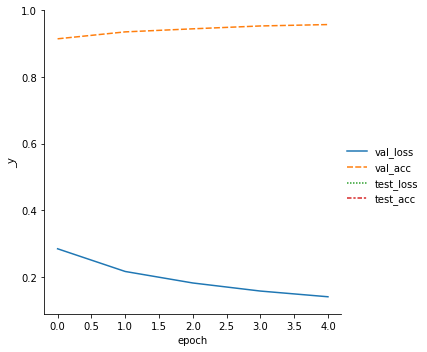

In [48]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")